In [1]:
import torch
import math
from dlc_practical_prologue import *
#torch.set_grad_enabled(False)

In [2]:
#INTERESTING FACT: WHEN COMPUTING THE BATCH GRADIENT PYTORCH DOES NOT TAKE THE SUM OF THE GRADIENTA OF SINGLE DATA POINTS
#BUT THE MEAN. I LEART AT THE EXPENSE OF ABOUT 1H LOL 

In [3]:
class Parameter():
    def __init__(self):
        self.name = ''
        self.data = None
        self.grad = None

In [4]:
class Module(object):
    def forward (self, *input):
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    
    def get_parameters( self ) :
        return []   

In [5]:
class Losses(object):        
    def forward():
        return NotImplementedError
    def backward():
        NotImplementedError

In [6]:
class Optimizer(object):
    def zero_grad(self):
        for parameter in self.param : 
            parameter.grad = 0
            
    def step(self):
        raise NotImplementedError

In [7]:
class SGD(Optimizer):
    # this is a SGD optimizer
    def __init__(self,lr,max_iter, parameters) :  
        super().__init__()
        self.eta = lr
        self.maxStep = max_iter 
        self.param = parameters
        self.number_step = 0

    def step(self): 
        if self.number_step <=self.maxStep:
            for parameter in self.param :
                parameter.data = parameter.data - self.eta * parameter.grad
            self.number_step = self.number_step + 1
        return self.param

In [8]:
class Linear(Module):
    
    def __init__(self, input_dim, out_dim, bias = True):
        super().__init__()
        std = 1/math.sqrt(input_dim)
        self.weight = Parameter()
        self.parameters = []
        
        self.weight.data = torch.rand(out_dim, input_dim)
        self.weight.data = 2*std*self.weight.data - std
        self.weight.name = 'weight'
        self.parameters += [self.weight]
        
        self.with_bias = bias
        if bias :
            self.bias = Parameter()
            self.bias.data = torch.rand(out_dim)
            self.bias.data = 2*std*self.bias.data - std
            self.bias.data = self.bias.data.unsqueeze(0)
            self.bias.name = 'bias'
            self.parameters +=[self.bias]
            
        self.x = None
              
    def forward(self, x):
        self.x = x
        self.batch_size = x.shape[0]
        return self.x.mm(self.weight.data.T) + self.bias.data
        
    def backward(self, prev_grad):
        
        prev_grad = prev_grad.view(self.batch_size, -1, 1)
        #print(prev_grad.shape)
        if self.x is None:
            raise CallForwardFirst
        
        if self.weight.grad is None:
            self.weight.grad = torch.zeros_like(self.weight.data)
        
        grad_on_batch = prev_grad.view(self.batch_size, -1, 1)*self.x.view(self.batch_size, 1, -1)
        self.weight.grad += grad_on_batch.mean(0)
        
        if self.with_bias:
            if self.bias.grad is None:
                self.bias.grad = torch.zeros_like(self.bias.data)
            grad_on_batch = prev_grad.view(self.batch_size, -1)
            self.bias.grad += grad_on_batch.mean(0)
        
        #if the output has dimension one, squeezing creates problems
        if prev_grad.shape[1]>1:
            prev_grad = prev_grad.squeeze()
        next_grad = prev_grad@self.weight.data
        return next_grad.squeeze()
    
    def get_parameters(self):
        return self.parameters    

In [9]:
class Tanh(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.tanh(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return d(self.x)*prev_grad
    

In [10]:
class MSE(Losses):
    # Attention! Works well only when the vectors provided are of the form [batch_size, vector dimension]
    # Otherwise it doesn know what dimesion to pick for the mean computation
    #I'll fix this later
    def __init__(self):
        self.x = None
    def forward(self, x, t):
        self.x = x
        self.t = t
        return (x - t).pow(2).mean()
    
    def backward(self):
        if self.x == None or self.t == None:
            raise CallForwardFirst
        return 2 * (self.x - self.t)/self.x.shape[1]

In [11]:
class Sequential(object):
    def __init__(self, modules):
        super().__init__()
        self.modules=modules
        self.parameters = []
        for m in self.modules:
            param = m.get_parameters()
            if param:
                self.parameters += param
        
    def forward(self,x):
        for m in self.modules:
            x=m.forward(x)
        return x
    
    def backward(self, loss_grad):
        x = loss_grad
        for m in reversed(self.modules):
            x = m.backward(x)
            
    def get_parameters(self):
        return self.parameters

    def set_parameters(self , params):
        self.parameters = params
        

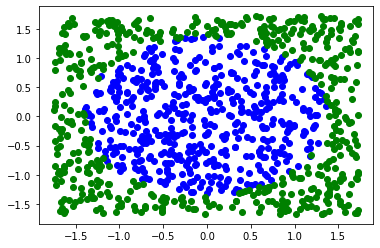

In [12]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0, 1)
    target = (input_-0.5).pow(2).sum(1).sub(1 / (math.pi*2)).sign().add(1).div(2).long()
    return input_, target
input_data, output_data=generate_disc_set(1000)
output_data=1-output_data
input_data-=input_data.mean(0)
input_data/=input_data.std(0)
import matplotlib.pyplot as plt
plt.plot(input_data[:,0][output_data==1],input_data[:,1][output_data==1],'bo')
plt.plot(input_data[:,0][output_data!=1],input_data[:,1][output_data!=1],'go')

In [13]:
#output_data = 2*output_data -1
print(input_data, input_data.shape, output_data.shape)

tensor([[-0.0231,  0.9301],
        [-1.4414, -1.2243],
        [-0.6799,  0.4758],
        ...,
        [-0.9371,  1.0547],
        [ 0.1064,  0.0881],
        [-0.5383,  1.2975]]) torch.Size([1000, 2]) torch.Size([1000])


In [14]:
#we should use one hot label embedding with MSELoss. Hence it is necessary to implement a Softmax
#Maybe we should also implement CrossEntropyLoss
#print(input_data.shape, output_data.shape)
#output_data = convert_to_one_hot_labels(input_data, output_data)
#print(input_data.shape, output_data.shape)

In [15]:
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [19]:
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**3
N=output_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    for i in range(N):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        # Compute and print loss.
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  964.0357666015625
10    MSE loss =  918.4002075195312
20    MSE loss =  860.0148315429688
30    MSE loss =  781.876708984375
40    MSE loss =  683.5006103515625
50    MSE loss =  577.1246948242188
60    MSE loss =  482.00128173828125
70    MSE loss =  407.9869689941406
80    MSE loss =  353.34814453125
90    MSE loss =  312.87115478515625
100    MSE loss =  282.1074523925781
110    MSE loss =  279.4369812011719
120    MSE loss =  279.4369812011719
130    MSE loss =  279.4369812011719
140    MSE loss =  279.4369812011719
150    MSE loss =  279.4369812011719
160    MSE loss =  279.4369812011719
170    MSE loss =  279.4369812011719
180    MSE loss =  279.4369812011719
190    MSE loss =  279.4369812011719
200    MSE loss =  279.4369812011719
210    MSE loss =  279.4369812011719
220    MSE loss =  279.4369812011719
230    MSE loss =  279.4369812011719
240    MSE loss =  279.4369812011719
250    MSE loss =  279.4369812011719
260    MSE loss =  279.4369812011719
270    MSE lo

In [23]:
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

Correct predictions after 1000 training steps: 97.2 %


In [24]:
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**3
N=output_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    for b in range(0, N, batch_size):
        predictions = net.forward(input_data[b:b+batch_size])
        l= loss.forward(predictions, output_data[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  3.2218475341796875
1    MSE loss =  3.1584525108337402
2    MSE loss =  3.0968589782714844
3    MSE loss =  3.0370242595672607
4    MSE loss =  2.9789063930511475
5    MSE loss =  2.9224634170532227
6    MSE loss =  2.8676540851593018
7    MSE loss =  2.814436435699463
8    MSE loss =  2.762770652770996
9    MSE loss =  2.712615966796875
10    MSE loss =  2.681093215942383
11    MSE loss =  2.6805968284606934
12    MSE loss =  2.6805968284606934
13    MSE loss =  2.6805968284606934
14    MSE loss =  2.6805968284606934
15    MSE loss =  2.6805968284606934
16    MSE loss =  2.6805968284606934
17    MSE loss =  2.6805968284606934
18    MSE loss =  2.6805968284606934
19    MSE loss =  2.6805968284606934
20    MSE loss =  2.6805968284606934
21    MSE loss =  2.6805968284606934
22    MSE loss =  2.6805968284606934
23    MSE loss =  2.6805968284606934
24    MSE loss =  2.6805968284606934
25    MSE loss =  2.6805968284606934
26    MSE loss =  2.6805968284606934
27    MSE loss 

223    MSE loss =  2.6805968284606934
224    MSE loss =  2.6805968284606934
225    MSE loss =  2.6805968284606934
226    MSE loss =  2.6805968284606934
227    MSE loss =  2.6805968284606934
228    MSE loss =  2.6805968284606934
229    MSE loss =  2.6805968284606934
230    MSE loss =  2.6805968284606934
231    MSE loss =  2.6805968284606934
232    MSE loss =  2.6805968284606934
233    MSE loss =  2.6805968284606934
234    MSE loss =  2.6805968284606934
235    MSE loss =  2.6805968284606934
236    MSE loss =  2.6805968284606934
237    MSE loss =  2.6805968284606934
238    MSE loss =  2.6805968284606934
239    MSE loss =  2.6805968284606934
240    MSE loss =  2.6805968284606934
241    MSE loss =  2.6805968284606934
242    MSE loss =  2.6805968284606934
243    MSE loss =  2.6805968284606934
244    MSE loss =  2.6805968284606934
245    MSE loss =  2.6805968284606934
246    MSE loss =  2.6805968284606934
247    MSE loss =  2.6805968284606934
248    MSE loss =  2.6805968284606934
249    MSE l

446    MSE loss =  2.6805968284606934
447    MSE loss =  2.6805968284606934
448    MSE loss =  2.6805968284606934
449    MSE loss =  2.6805968284606934
450    MSE loss =  2.6805968284606934
451    MSE loss =  2.6805968284606934
452    MSE loss =  2.6805968284606934
453    MSE loss =  2.6805968284606934
454    MSE loss =  2.6805968284606934
455    MSE loss =  2.6805968284606934
456    MSE loss =  2.6805968284606934
457    MSE loss =  2.6805968284606934
458    MSE loss =  2.6805968284606934
459    MSE loss =  2.6805968284606934
460    MSE loss =  2.6805968284606934
461    MSE loss =  2.6805968284606934
462    MSE loss =  2.6805968284606934
463    MSE loss =  2.6805968284606934
464    MSE loss =  2.6805968284606934
465    MSE loss =  2.6805968284606934
466    MSE loss =  2.6805968284606934
467    MSE loss =  2.6805968284606934
468    MSE loss =  2.6805968284606934
469    MSE loss =  2.6805968284606934
470    MSE loss =  2.6805968284606934
471    MSE loss =  2.6805968284606934
472    MSE l

663    MSE loss =  2.6805968284606934
664    MSE loss =  2.6805968284606934
665    MSE loss =  2.6805968284606934
666    MSE loss =  2.6805968284606934
667    MSE loss =  2.6805968284606934
668    MSE loss =  2.6805968284606934
669    MSE loss =  2.6805968284606934
670    MSE loss =  2.6805968284606934
671    MSE loss =  2.6805968284606934
672    MSE loss =  2.6805968284606934
673    MSE loss =  2.6805968284606934
674    MSE loss =  2.6805968284606934
675    MSE loss =  2.6805968284606934
676    MSE loss =  2.6805968284606934
677    MSE loss =  2.6805968284606934
678    MSE loss =  2.6805968284606934
679    MSE loss =  2.6805968284606934
680    MSE loss =  2.6805968284606934
681    MSE loss =  2.6805968284606934
682    MSE loss =  2.6805968284606934
683    MSE loss =  2.6805968284606934
684    MSE loss =  2.6805968284606934
685    MSE loss =  2.6805968284606934
686    MSE loss =  2.6805968284606934
687    MSE loss =  2.6805968284606934
688    MSE loss =  2.6805968284606934
689    MSE l

886    MSE loss =  2.6805968284606934
887    MSE loss =  2.6805968284606934
888    MSE loss =  2.6805968284606934
889    MSE loss =  2.6805968284606934
890    MSE loss =  2.6805968284606934
891    MSE loss =  2.6805968284606934
892    MSE loss =  2.6805968284606934
893    MSE loss =  2.6805968284606934
894    MSE loss =  2.6805968284606934
895    MSE loss =  2.6805968284606934
896    MSE loss =  2.6805968284606934
897    MSE loss =  2.6805968284606934
898    MSE loss =  2.6805968284606934
899    MSE loss =  2.6805968284606934
900    MSE loss =  2.6805968284606934
901    MSE loss =  2.6805968284606934
902    MSE loss =  2.6805968284606934
903    MSE loss =  2.6805968284606934
904    MSE loss =  2.6805968284606934
905    MSE loss =  2.6805968284606934
906    MSE loss =  2.6805968284606934
907    MSE loss =  2.6805968284606934
908    MSE loss =  2.6805968284606934
909    MSE loss =  2.6805968284606934
910    MSE loss =  2.6805968284606934
911    MSE loss =  2.6805968284606934
912    MSE l

In [25]:
correct=0
for i in range(output_data.shape[0]):
        x=input_data[i]
        y=2*output_data[i]-1
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = net.forward(x.unsqueeze(0))
        if abs(y_pred-output_data[i])<1:
            correct+=1
print('Correct predictions after '+str(n)+' training steps: '+str(correct/N*100)+' %')

Correct predictions after 1000 training steps: 99.3 %
